In [1]:
import sys
sys.path.append('../')
sys.path.append('../../')

from DataProc.DataProcessor import DataProcessor
from Datasets.BaseballDataset import BaseballDataset
from BaselineModel.BaselineModel import BaselineModel
from TransformerModel.TransformerModelRedisual import *

import torch
import torch.nn as nn
import torch.optim as optim
import math
import torch.nn.functional as F
from torch.utils.data import DataLoader
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler

In [2]:
data_config_path = "../../data/configv2.json"
full_data_path = "../../data/full_cleaned_zone_93.csv"
sequence_length = 400
full_data = pd.read_csv(full_data_path)


In [3]:
scaler_path = "../../data/full_scalers_zone_93.pkl"

In [4]:
#only use 2024 data for now
data_2024 = full_data[full_data['game_date'] > '2024-01-01']

#player names in 2024
names = data_2024['batter_name'].unique()

In [5]:
m_path = "../hit_loc_fixed_400/h6_e12_h96_d0_lp0.5_lr1e-05_ep50/transformer_model.pth"
c_path = "../hit_loc_fixed_400/h6_e12_h96_d0_lp0.5_lr1e-05_ep50/model_config.json"

transformer_model = TransformerHelper(m_path,c_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import warnings



# I expect to see RuntimeWarnings in this block
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)

    verbose = False
    cont_errors = []

    events_errors = []
    events_precisions = []

    loc_errors = []
    loc_precisions = []

    player_names = []
    data_sizes = []

    all_event_preds = []
    all_loc_preds = []

    all_event_true = []
    all_loc_true = []



    for name in names:
        # Create dataset for this player
        player_data = data_2024[data_2024['batter_name'] == name].reset_index(drop=True)

        print(name,len(player_data))

        if len(player_data) < sequence_length:
            continue

        player_dataset = BaseballDataset(player_data, data_config_path, sequence_length)

        if len(player_dataset) < 1:
            continue

        player_names.append(name)
        data_sizes.append(len(player_dataset))

        #print(name,len(player_dataset))

        # Get preds and true using this dataset
        player_preds, player_true = transformer_model.make_preds(player_dataset, scaler_path, device, 2000, scale=True)

        #print(player_preds.columns)

        # First 4 columns are continuous preds/labels
        cont_preds = player_preds.iloc[:, 0:4]
        cont_true = player_true.iloc[:, 0:4]

        # Next 10 columns are probabilities for the events categorical feature
        events_preds = player_preds.iloc[:, 4:14]
        events_true = player_true.iloc[:, 4:14]



        # Last 10 columns are probabilities for the hit_location categorical feature
        loc_preds = player_preds.iloc[:, 14:]
        loc_true = player_true.iloc[:, 14:]


        cont_error = np.abs(cont_true - cont_preds)
        cont_errors.append(cont_error)




        # Summing the probability distributions for events and hit_location
        pred_events_sum = events_preds.sum(axis=0)
        true_events_sum = events_true.sum(axis=0)


        all_event_preds.append(pred_events_sum)
        all_event_true.append(true_events_sum)

        pred_loc_sum = loc_preds.sum(axis=0)
        true_loc_sum = loc_true.sum(axis=0)

        all_loc_preds.append(pred_loc_sum)
        all_loc_true.append(true_loc_sum)


        events_sum_abs_errors = np.abs(pred_events_sum - true_events_sum).values
        loc_sum_abs_errors = np.abs(pred_loc_sum - true_loc_sum).values

        if verbose:
            print(f"Sum of absolute errors for Events for {name}: {events_sum_abs_errors}")
            print(f"Sum of absolute errors for Hit Location for {name}: {loc_sum_abs_errors}")

        events_errors.append(events_sum_abs_errors)
        loc_errors.append(loc_sum_abs_errors)


        top_k = 4

        # Get top-k predictions for each sample, returning the numeric index instead of column names
        events_top_k_preds = events_preds.apply(lambda x: x.nlargest(top_k).index.map(lambda name: events_preds.columns.get_loc(name)), axis=1)
        loc_top_k_preds = loc_preds.apply(lambda x: x.nlargest(top_k).index.map(lambda name: loc_preds.columns.get_loc(name)), axis=1)

        # Now the predictions are stored as the numeric indices corresponding to the classes

        # Compute precision for each class
        events_class_precisions = []
        loc_class_precisions = []

        # For each class in events and hit_location, calculate top-k precision
        for class_idx in range(10):
            # For events precision
            true_class_mask = events_true.iloc[:, class_idx] == 1  # Find where this class is the true class
            true_class_indices = events_true.index[true_class_mask]
            
            # Check if this class is in the top-k predictions when it's the true class
            event_precision = np.mean([1 if class_idx in events_top_k_preds.iloc[i] else 0 for i in true_class_indices])
            events_class_precisions.append(event_precision)

            # For hit location precision
            true_class_mask = loc_true.iloc[:, class_idx] == 1  # Find where this class is the true class
            true_class_indices = loc_true.index[true_class_mask]

            # Check if this class is in the top-k predictions when it's the true class
            loc_precision = np.mean([1 if class_idx in loc_top_k_preds.iloc[i] else 0 for i in true_class_indices])
            loc_class_precisions.append(loc_precision)

        if verbose:
            print(f"Class-wise Events Precision for {name}: {events_class_precisions}")
            print(f"Class-wise Hit Location Precision for {name}: {loc_class_precisions}")

        events_precisions.append(events_class_precisions)
        loc_precisions.append(loc_class_precisions)





    





zack gelof 1004


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


tyler nevin 709


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


kyle mccann 395
ketel marte 1365


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


corbin carroll 1376


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


geraldo perdomo 357
josé herrera 47
eugenio suárez 1368


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


tyler soderstrom 520


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


brent rooker 1213


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


miguel andújar 518


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jake mccarthy 844


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


lourdes gurriel 1298


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


christian walker 1575


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


blaze alexander 701


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


randal grichuk 501


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jj bleday 1349


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


aledmys díaz 101
daz cameron 287
joc pederson 1039


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


lawrence butler 677


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


tucker barnhart 403
zack short 391
orlando arcia 1209


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


sean murphy 357
adam duvall 797


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


austin riley 1141


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


connor joe 1157


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jack suwinski 955


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jared triolo 1047


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


matt olson 1521


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


marcell ozuna 1438


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ozzie albies 1265


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jarred kelenic 955


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


joey bart 313
nick gonzales 678


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


rowdy tellez 947


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


travis d'arnaud 693


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


edward olivares 784


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


oneil cruz 1293


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


bryan reynolds 1513


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


luke williams 38
andrew mccutchen 1321


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


colton cowser 1113


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


heston kjerstad 176
jorge mateo 709


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ryan o'hearn 942


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


austin hays 451
robbie grossman 680


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


josh smith 1145


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


marcus semien 1353


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


davis wendzel 170
jordan westburg 1232


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


anthony santander 1330


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


adley rutschman 1476


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


andrew knizner 292
derek hill 86
nathaniel lowe 1048


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


wyatt langford 1035


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


adolis garcía 1272


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


gunnar henderson 1487


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ha-seong kim 1430


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jackson merrill 1151


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


donovan solano 620


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


dominic smith 641


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


masataka yoshida 598


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


enmanuel valdez 745


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


manny machado 1237


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jake cronenworth 1454


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jurickson profar 1433


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


luis arráez 1389


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


rafael devers 1239


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


romy gonzalez 230
rob refsnyder 649


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jarren duran 1535


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ceddanne rafaela 1091


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


david peralta 265
kyle higashioka 431
reese mcguire 549


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


wilyer abreu 937


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


david hamilton 663


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


bryce johnson 83
nicky lopez 879


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


lenyn sosa 500


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


andrew benintendi 936


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


nolan jones 758


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


michael toglia 627


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


sam hilliard 56
paul dejong 1091


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


eloy jiménez 606


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


luis robert 520


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


andrew vaughn 1248


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ryan mcmahon 1542


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ezequiel tovar 1355


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


brenton doyle 1198


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jake cave 683


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


tommy pham 859


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


korey lee 797


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


brendan rodgers 1052


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


hunter goodman 417
gavin sheets 1181


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


elías díaz 880


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


corey julks 496


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


charlie blackmon 1011


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


aaron schunk 24
martín maldonado 497


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


danny mendick 470
tyler freeman 1053


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


bo naylor 842


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


andrés giménez 1297


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


maikel garcía 1412


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


dairon blanco 311
garrett hampson 458
jhonkensy noel 51


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


josh naylor 1159


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


josé ramírez 1397


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


daniel schneemann 329
steven kwan 1001


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


gabriel arias 577


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


freddy fermin 622


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


nick loftin 498


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


hunter renfroe 856


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


salvador pérez 1183


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


vinnie pasquantino 1337


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


bobby witt 1416


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


david fry 863


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


josé tena 18
brayan rocchio 977


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


nolan schanuel 1237


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jo adell 1039


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


mickey moniak 895


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


zach neto 1156


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


matt thaiss 332
miguel sanó 428
brandon drury 505


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


taylor ward 1397


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


andy ibáñez 543


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ryan kreidler 191
akil baddoo 246
luis guillorme 424
gio urshela 823


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


wenceel pérez 1016


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


carson kelly 699


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jake rogers 731


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


riley greene 1551


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


mark canha 1377


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


luis rengifo 942


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


justyn-henry malloy 405
logan o'hoppe 1043


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


willie calhoun 623


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


miles mastrobuoni 215
seiya suzuki 1067


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


cody bellinger 1100


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


brice turang 1267


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


andruw monasterio 282
jackson chourio 942


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


sal frelick 1065


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


rhys hoskins 1100


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jake bauers 805


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


michael busch 1203


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


nico hoerner 1164


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


miguel amaya 688


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


pete crow-armstrong 505


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


willy adames 1436


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


christian yelich 973


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


william contreras 1378


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


dansby swanson 1161


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


christopher morel 1339


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ian happ 1415


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jeff mcneil 1094


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


luis torrens 204
tyrone taylor 705


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


chas mccormick 615


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


trey cabbage 193
mauricio dubón 745


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jeremy peña 1234


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


joey loperfido 260
jake meyers 884


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


yainer diaz 1067


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


mark vientos 605


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


harrison bader 974


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


j. d. martinez 962


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


brandon nimmo 1543


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


alex bregman 1353


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


francisco lindor 1493


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jon singleton 816


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


dj stewart 688


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


yordan álvarez 1302


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


pete alonso 1446


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


josé altuve 1336


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ben gamel 8
tim anderson 987


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jesús sánchez 963


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jake burger 964


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


josh bell 1299


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


david dahl 247
whit merrifield 646


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


edmundo sosa 726


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


nick castellanos 1338


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


brandon marsh 1083


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


bryan de la cruz 1423


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


otto lopez 580


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jazz chisholm 1420


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


alec bohm 1273


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


trea turner 828


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


bryson stott 1297


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ali sánchez 101
emmanuel rivera 583


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


dane myers 334
rafael marchán 114
kody clemens 237
shohei ohtani 1503


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


austin barnes 336
enrique hernández 767


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


chris taylor 540


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


gavin lux 956


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jason heyward 500


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


luis matos 416
matt chapman 1491


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


patrick bailey 891


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


heliot ramos 865


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


austin slater 465
andy pages 1052


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


cavan biggio 799


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


miguel vargas 161
jorge soler 1155


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


tyler fitzgerald 340
nick ahmed 562


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


david villar 52
freddie freeman 1459


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


teoscar hernández 1436


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


mitch haniger 1143


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


luke raley 869


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


cal raleigh 1313


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


kyle farmer 515


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


max kepler 890


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


byron buxton 901


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


julio rodríguez 1448


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


josh rojas 1056


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


j. p. crawford 1181


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


carlos santana 1309


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


royce lewis 404
trevor larnach 722


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


josé miranda 876


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


willi castro 1348


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


dylan moore 1005


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ty france 1148


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jorge polanco 892


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


víctor robles 228
christian vázquez 612


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


austin martin 468
ryan bliss 222


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


luis castillo 3
mitch garver 1210


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


spencer steer 1370


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jeimer candelario 1118


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


elly de la cruz 1437


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


pedro pagés 316
nolan gorman 1256


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


nolan arenado 1339


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jonathan india 1311


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


luke maile 462
levi jordan 40
brendan donovan 1362


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


paul goldschmidt 1576


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


willson contreras 639


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


santiago espinal 738


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


noelvi marte 65
jake fraley 758


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


alec burleson 1040


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


masyn winn 1225


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


michael siani 723


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


will benson 1108


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


stuart fairchild 613


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ildemaro vargas 612


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


joey meneses 1097


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


luis garcía 1007


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jonny deluca 529


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


josé siri 1064


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


isaac paredes 1525


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


harold ramírez 703


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jesse winker 1302


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


lane thomas 978


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


cj abrams 1236


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jacob young 897


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


amed rosario 843


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


randy arozarena 1468


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


yandy díaz 1498


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


alex jackson 366
drew millas 139
taylor walls 230
josé caballero 1073


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


danny jansen 763


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


daulton varsho 1230


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


george springer 1249


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


justin turner 1341


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


trent grisham 481


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


dj lemahieu 382
austin wells 678


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ben rice 199
davis schneider 1201


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


spencer horwitz 306
isiah kiner-falefa 1019


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


gleyber torres 1540


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


alex verdugo 1370


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


aaron judge 1577


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


juan soto 1672


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


kevin kiermaier 703


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ernie clement 543


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


anthony volpe 1617


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


vladimir guerrero 1478


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


armando alvarez 84
kevin newman 654


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


shea langeliers 972


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


max schuemann 854


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ke'bryan hayes 992


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


yasmani grandal 445
forrest wall 80
michael taylor 756


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


leody taveras 1107


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ryan mountcastle 1273


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ramón urías 531


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


cedric mullins 950


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jonah heim 997


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


corey seager 1096


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


connor wong 880


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


tyler wade 407
brett sullivan 39
tyler o'neill 1050


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


elehuris montero 969


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jacob stallings 547


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


kyle isbel 777


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


mj melendez 1063


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


michael massey 442
kevin pillar 625


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


colt keith 1043


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


matt vierling 1236


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


zach mckinstry 625


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


tyler black 161
blake perkins 1001


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


tomás nido 396
francisco álvarez 535


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jose iglesias 199
césar salazar 77
cristian pache 468
nick gordon 828


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


johan rojas 812


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


nick fortes 571


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


garrett stubbs 409
brett wisely 411
miguel rojas 603


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


will smith 1239


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


lamonte wade 755


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


michael conforto 917


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ryan jeffers 1106


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


carlos correa 1089


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


dylan carlson 491


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


austin wynns 16
matt carpenter 435
nick martini 562


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


josh lowe 538


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


brandon lowe 570


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ben rortvedt 762


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


nasim nuñez 68
richie palacios 994


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


nick senzel 871


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


keibert ruiz 754


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


oswaldo cabrera 852


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


bo bichette 1096


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


alejandro kirk 720


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


travis jankowski 504


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


james mccann 422
austin hedges 307
patrick wisdom 373
cooper hummel 23
vidal bruján 602


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


manuel margot 740


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


dominic canzone 548


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


brandon crawford 247
eddie rosario 899


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jahmai jones 190
jose trevino 675


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


addison barger 198
j. d. davis 577


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


bryce harper 1309


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


kyle schwarber 1535


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


wilmer flores 923


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


thairo estrada 1085


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


curt casali 187
josé fermín 242
tyler stephenson 846


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jason delay 87
livan soto 10
joey ortiz 1023


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


eguy rosario 237
ramón laureano 481


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


johnathan rodríguez 175
cj alexander 18
ezequiel duran 695


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


will brennan 837


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


tyler heineman 9
michael stefanic 145
tj friedl 408
angel martínez 14
alan trejo 249
trey lipscomb 492


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


gary sánchez 655


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


trenton brooks 110
nelson velázquez 903


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


starling marte 1102


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


sean bouchard 460
giancarlo stanton 1198


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


josé azocar 305
adam frazier 668


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


david bote 78
bobby dalbec 489


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


orelvis martinez 11
oscar colás 144
abraham toro 1178


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


gabriel moreno 998


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


fernando tatís 1255


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


tyler locklear 127
adael amador 125
luis campusano 743


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


mike yastrzemski 931


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


víctor caratini 399
jacob hurtubise 277
iván herrera 793


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


christian bethancourt 365
mike tauchman 1127


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


greg jones 45
sam huff 21
j. p. martínez 42
anthony rizzo 1114


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


mookie betts 1375


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


seth brown 804


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


cole tucker 237
kyle manzardo 355
jamie westbrook 120
yan gomes 381
michael harris 981


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


kyle stowers 162
henry davis 513


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


drew waters 34
weston wilson 39
zach deloach 91
seby zavala 194
brian anderson 15
oliver dunn 417
dan vogelbach 395
josé abreu 551


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


blake dunn 44
joey gallo 718


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


alex kirilloff 708


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


casey schmitt 123
garrett cooper 462
duke ellis 19
tristan gray 56


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


xavier edwards 51
j. t. realmuto 947


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


brett baty 758


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


javier báez 741


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


pavin smith 216
connor norby 99
kyren paris 233
kyle tucker 1092


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jonathan aranda 249
edouard julien 868


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


kris bryant 464
dominic fletcher 349
ji hwan bae 102


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


grant koch 58
spencer torkelson 1061


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


vaughn grissom 336
riley adams 412
zach remillard 156
nick madrigal 357
owen miller 103
omar narváez 304
bryan ramos 172
lars nootbaar 687


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


alika williams 289
marco luciano 138
mike ford 229
estevan florial 500


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jonatan clase 138
kerry carpenter 699


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


evan carter 680


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ryan mckenna 64
ronald acuña 913


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


chadwick tromp 196
jordan beck 301
jon berti 279
luis urías 393
luis vázquez 4
brett harris 229
xander bogaerts 817


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


joey wiemer 103
esteury ruiz 294
blake sabol 128
james outman 537


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


conner capel 25
braden shewmake 234
chris roller 6
max muncy 739


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


rafael ortega 83
joey wendle 168
sam haggerty 59
austin shenton 227
niko goodrum 170
jakson reetz 37
grae kessinger 71
ryan vilade 80
leo rivas 28
jung hoo lee 601


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ehire adrianza 133
christian encarnacion-strand 451
jacob amaya 5
jonathan ornelas 9
darell hernaiz 323


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


parker meadows 449
jonah bride 67
tom murphy 161
alex call 124
matt mervis 97
curtis mead 370
ryan noda 473


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


graham pauley 155
alexander canario 106
mike trout 627


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


nick allen 283
rené pinto 213
aaron hicks 328
taylor trammell 44
pablo reyes 318
buddy kennedy 112
avisaíl garcía 230
bubba thompson 77
david fletcher 27
jackson holliday 170
jordan walker 309
jhonny pereda 19
anthony rendon 413


c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\declan\anaconda3\envs\pytorchCUDA\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


jair camargo 19
triston casas 409
victor scott 240
jace peterson 133
matthew batten 11
david bañuelos 9
jared walsh 279
matt wallner 170
brian serven 79
tony kemp 37
yoán moncada 188
samad taylor 36
justin foscue 23
trevor story 150
scott mcgough 4
jorge barrosa 33
josh jung 110
alek thomas 79
nan 0
brian o'keefe 33
mark contreras 36
elier hernandez 4
mark kolozsvary 19
eddy alvarez 32
jack lópez 11
pablo sandoval 18
hoy park 35
carlos pérez 34
luis de los santos 18
steward berroa 15
leo jimenez 12
gilberto celestino 57
jake lamb 47
andrew knapp 6
donovan walton 4
michael pérez 7
luke voit 39
anthony bemboom 22
bligh madris 31
símon muzziotti 19
jake marisnick 10
chad wallach 6
billy mckinney 50
luis gonzález 45
josh vanmeter 13
connor kaiser 1
brett phillips 6
chuckie robinson 2
mark payton 7
dalton guthrie 5
nick sogard 6
dillon dingler 28
tj hopkins 3
pedro león 22
ji man choi 79
juan yepez 24
carlos narvaez 7
jordan groshans 10
oscar gonzález 26
esteban quiroz 18
greg allen 28
josé

In [8]:
cont_errors[0]

,launch_speed,hc_x,hc_y,launch_angle
0,3.402311,12.184688,7.412046,0.233983
1,8.426523,1.558742,0.246004,12.541182
2,0.261992,0.308520,0.161139,0.795506
3,3.367613,0.027551,0.204442,0.231576
4,0.757037,0.695675,0.568206,1.701210
...,...,...,...,...
599,2.475623,10.095565,5.783389,7.409182
600,11.557759,2.839656,1.506447,40.494480
601,10.853644,1.196050,0.516718,22.437828
602,0.185181,0.390659,0.860409,1.549920


In [9]:
event_class_names = player_dataset.categorical_label_names[0]
loc_class_names = player_dataset.categorical_label_names[1]



# Summary Statistics for Class-wise Errors and Precisions
average_events_class_errors = np.nanmean(events_errors, axis=0)
average_loc_class_errors = np.nanmean(loc_errors, axis=0)

average_events_class_precisions = np.nanmean(events_precisions, axis=0)
average_loc_class_precisions = np.nanmean(loc_precisions, axis=0)

# Create DataFrames for the results
events_summary_df = pd.DataFrame({
    'Class': event_class_names,
    'Average Error': average_events_class_errors,
    f'Average Precision (Top K {top_k})': average_events_class_precisions
})

loc_summary_df = pd.DataFrame({
    'Class': loc_class_names,
    'Average Error': average_loc_class_errors,
    f'Average Precision (Top {top_k})': average_loc_class_precisions
})

# Print formatted DataFrames
print("Events Class-wise Summary:")
print(events_summary_df)

print("\nHit Location Class-wise Summary:")
print(loc_summary_df)

Events Class-wise Summary:
                 Class  Average Error  Average Precision (Top K 4)
0             events_B       0.832898                     0.999070
1             events_S       0.658382                     0.998670
2        events_double       2.045372                     0.917709
3     events_field_out       9.353820                     0.999648
4  events_hit_by_pitch       0.612318                     0.987376
5      events_home_run       2.463169                     0.743844
6        events_single       3.534683                     0.997813
7     events_strikeout       6.856114                     0.999433
8        events_triple       0.650070                     0.000000
9          events_walk       1.409117                     0.972409

Hit Location Class-wise Summary:
              Class  Average Error  Average Precision (Top 4)
0  hit_location_0.0       7.050020                   0.995618
1  hit_location_1.0       1.385307                   0.071424
2  hit_location_

In [10]:
total_error = events_summary_df['Average Error'].sum()

print(f'Average num pitches in datasets: {sum(data_sizes) / len(data_sizes)}')
print(f'Total average error: {total_error}')

Average num pitches in datasets: 535.472
Total average error: 28.41594123840332


In [11]:
pname = "bryce harper"
idx = player_names.index(pname)


# Create a DataFrame for events errors and precisions
events_df = pd.DataFrame({
    "Error": events_errors[idx],
    "Precision": events_precisions[idx]
}, index=event_class_names)


# Output the DataFrames
print(f"Events DataFrame for {pname}:")
print(f"Num pitches: {data_sizes[idx]}")
print(events_df)

print("\nModel Preds")
print(all_event_preds[idx])
print("\nTrue")
print(all_event_true[idx])


Events DataFrame for bryce harper:
Num pitches: 909
                        Error  Precision
events_B             3.125977   1.000000
events_S             0.829620   1.000000
events_double        3.964178   0.937500
events_field_out     7.355667   1.000000
events_hit_by_pitch  2.271540        NaN
events_home_run      5.759680   0.785714
events_single        5.879448   0.971429
events_strikeout     4.494747   1.000000
events_triple        1.013228        NaN
events_walk          3.487486   0.965517

Model Preds
events_B               327.125977
events_S               353.829620
events_double           12.035822
events_field_out        94.355667
events_hit_by_pitch      2.271540
events_home_run          8.240320
events_single           29.120552
events_strikeout        55.494747
events_triple            1.013228
events_walk             25.512514
dtype: float32

True
events_B               324.0
events_S               353.0
events_double           16.0
events_field_out        87.0
events_

In [59]:
#baseline for this comparison will simply be using a players career averages

#pre-2024 data for averages since we are predicting 2024 stats
baseline_data = full_data[full_data['game_date'] < '2024-01-01']

baseline_events_errors = []
baseline_loc_errors = []


for i, player in enumerate(player_names):


    #get pre-2024 data for this player

    player_data = baseline_data[baseline_data['batter_name'] == player]

    
    if len(player_data) == 0:
        continue
    
    event_cols = ['events_B', 'events_S', 'events_double',
       'events_field_out', 'events_hit_by_pitch', 'events_home_run',
       'events_single', 'events_strikeout', 'events_triple', 'events_walk']
    
    player_event_means = player_data[event_cols].sum(axis=0) / len(full_data)

    #multiply by number of pitches seen for 2024 (won't be entire 2024 since the dataset skips first sequence_length (200) pitches)

    baseline_event_preds = player_event_means * data_sizes[i]
    baseline_event_true = all_event_true[i] #true will be the same as before


    baseline_events_sum_abs_errors = np.abs(baseline_event_preds - baseline_event_true).values


    #same for hit_location

    loc_cols = ['hit_location_0.0', 'hit_location_1.0',
       'hit_location_2.0', 'hit_location_3.0', 'hit_location_4.0',
       'hit_location_5.0', 'hit_location_6.0', 'hit_location_7.0',
       'hit_location_8.0', 'hit_location_9.0']
    
    player_loc_means = player_data[loc_cols].sum(axis=0) / len(full_data)

    #multiply by number of pitches seen for 2024 (won't be entire 2024 since the dataset skips first sequence_length (200) pitches)

    baseline_loc_preds = player_loc_means * data_sizes[i]
    baseline_loc_true = all_loc_true[i] #true will be the same as before


    baseline_loc_sum_abs_errors = np.abs(baseline_loc_preds - baseline_loc_true).values



    baseline_events_errors.append(baseline_events_sum_abs_errors)
    baseline_loc_errors.append(baseline_loc_sum_abs_errors)


    


    

    


    

    
    

   
    


In [64]:
# Summary Statistics for Class-wise Errors and Precisions
average_baseline_events_class_errors = np.nanmean(baseline_events_errors, axis=0)
average_baseline_loc_class_errors = np.nanmean(baseline_loc_errors, axis=0)



# Create DataFrames for the results
baseline_events_summary_df = pd.DataFrame({
    'Class': event_class_names,
    'Average Error': average_baseline_events_class_errors
})

baseline_loc_summary_df = pd.DataFrame({
    'Class': loc_class_names,
    'Average Error': average_baseline_loc_class_errors
})

# Print formatted DataFrames
print("Events Class-wise Summary:")
print(baseline_events_summary_df)

print("\nHit Location Class-wise Summary:")
print(baseline_loc_summary_df)

Events Class-wise Summary:
                 Class  Average Error
0             events_B     213.817410
1             events_S     261.685699
2        events_double       7.112899
3     events_field_out      76.577997
4  events_hit_by_pitch       1.866922
5      events_home_run       4.820044
6        events_single      23.379887
7     events_strikeout      36.098786
8        events_triple       0.658866
9          events_walk      12.987322

Hit Location Class-wise Summary:
              Class  Average Error
0  hit_location_0.0     495.293815
1  hit_location_1.0       3.716910
2  hit_location_2.0      37.325584
3  hit_location_3.0       8.209939
4  hit_location_4.0      12.847200
5  hit_location_5.0      12.103291
6  hit_location_6.0      13.828818
7  hit_location_7.0      17.792462
8  hit_location_8.0      19.698064
9  hit_location_9.0      18.188721


In [83]:
#month to month comparison

#includes about ~200 pitches back from end of march so that we are making preds for every pitch in june
judge_2019_july_aug = full_data[(full_data['batter_name'] == 'josh naylor') & (full_data['game_date'] > '2023-01-1') & (full_data['game_date'] < '2023-10-01')].reset_index(drop=True)
judge_2019 = BaseballDataset(judge_2019_july_aug,data_config_path,sequence_length)

#includes about ~200 pitches back from end of may so that we are making preds for every pitch in june
judge_2022_july_aug = full_data[(full_data['batter_name'] == 'aaron judge') & (full_data['game_date'] > '2021-01-1') & (full_data['game_date'] < '2021-10-01')].reset_index(drop=True)
judge_2022 = BaseballDataset(judge_2022_july_aug,data_config_path,sequence_length)





judge_2019_preds, judge_2019_true = transformer_model.make_preds(judge_2019, scaler_path, device, 2000, scale=False)
judge_2022_preds, judge_2022_true = transformer_model.make_preds(judge_2022, scaler_path, device, 2000, scale=False)









In [70]:
judge_2019_preds[judge_2019_true['events_home_run'] == True]['launch_speed'].mean()

1.0665656

In [33]:
judge_2022_preds[judge_2022_true['events_home_run'] == True]['launch_speed'].mean()

93.3105724999965

In [84]:
print(f"total pitches: {judge_2019_preds.sum(axis=0)[4:14].sum(axis=0)}\n")


print("Conts")
print(judge_2019_preds.mean(axis=0)[0:4])
print()

print("Judge 2019 Preds")
print(judge_2019_preds.sum(axis=0)[4:])

print()
print("Judge April True")
print(judge_2019_true.sum(axis=0)[4:])



total pitches: 1247.9990234375

Conts
launch_speed   -0.039914
hc_x            0.062787
hc_y           -0.028651
launch_angle    0.073126
dtype: float32

Judge 2019 Preds
events_B               385.348358
events_S               485.631927
events_double           20.807783
events_field_out       203.990494
events_hit_by_pitch      3.676032
events_home_run         14.670452
events_single           54.443718
events_strikeout        63.313938
events_triple            1.955682
events_walk             14.160654
hit_location_0.0       963.508484
hit_location_1.0        11.820321
hit_location_2.0         2.942647
hit_location_3.0        25.540970
hit_location_4.0        45.707012
hit_location_5.0        19.440466
hit_location_6.0        29.387096
hit_location_7.0        47.068024
hit_location_8.0        58.876659
hit_location_9.0        43.708603
dtype: float32

Judge April True
events_B               385.0
events_S               486.0
events_double           27.0
events_field_out       192.0


In [85]:
print(f"total pitches: {judge_2022_preds.sum(axis=0)[4:14].sum(axis=0)}\n")

print("Conts")
print(judge_2022_preds.mean(axis=0)[0:4])
print()

print("Judge 2022 Preds")
print(judge_2022_preds.sum(axis=0)[4:])

print()
print("Judge 2022 True")
print(judge_2022_true.sum(axis=0)[4:])


total pitches: 2311.9921875

Conts
launch_speed    0.085427
hc_x           -0.026408
hc_y           -0.080444
launch_angle    0.014653
dtype: float32

Judge 2022 Preds
events_B                869.904602
events_S                898.624207
events_double            32.737087
events_field_out        150.475418
events_hit_by_pitch       2.854521
events_home_run          33.357109
events_single            75.719139
events_strikeout        183.654083
events_triple             2.044468
events_walk              62.621529
hit_location_0.0       2046.287231
hit_location_1.0          7.827031
hit_location_2.0          3.127434
hit_location_3.0          8.966259
hit_location_4.0         19.304184
hit_location_5.0         34.296520
hit_location_6.0         39.853558
hit_location_7.0         44.576485
hit_location_8.0         54.676083
hit_location_9.0         53.093044
dtype: float32

Judge 2022 True
events_B                867.0
events_S                896.0
events_double            23.0
events_fie

In [42]:
judge_2019_true

,launch_speed,hc_x,hc_y,launch_angle,events_B,events_S,events_double,events_field_out,events_hit_by_pitch,events_home_run,...,hit_location_0.0,hit_location_1.0,hit_location_2.0,hit_location_3.0,hit_location_4.0,hit_location_5.0,hit_location_6.0,hit_location_7.0,hit_location_8.0,hit_location_9.0
0,102.400001,72.659998,61.730000,20.000000,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,71.600000,126.660554,123.034914,48.999999,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,91.300000,82.780000,88.570001,19.000000,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,83.212881,126.660554,123.034914,16.275918,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,83.212881,126.660554,123.034914,16.275918,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2166,80.600000,195.120003,116.790000,39.999999,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2167,51.000000,126.660554,123.034914,-35.999999,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2168,83.212881,126.660554,123.034914,16.275918,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2169,83.212881,126.660554,123.034914,16.275918,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


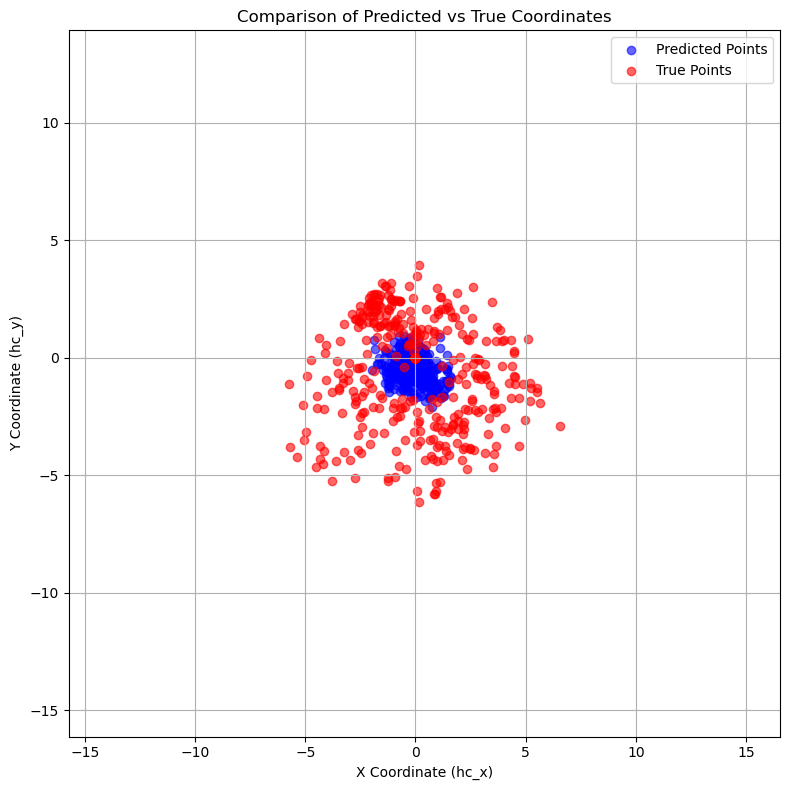

In [110]:
import matplotlib.pyplot as plt

df_pred = judge_2022_preds
df_true = judge_2022_true

# Generate the plot
plt.figure(figsize=(8, 8))

# Plot predicted points
plt.scatter(df_pred['hc_x'], df_pred['hc_y'], color='blue', label='Predicted Points', alpha=0.6)

# Plot true points
plt.scatter(df_true['hc_x'], df_true['hc_y'], color='red', label='True Points', alpha=0.6)

# Add labels and title
plt.xlabel('X Coordinate (hc_x)')
plt.ylabel('Y Coordinate (hc_y)')
plt.title('Comparison of Predicted vs True Coordinates')

# Add grid and legend
plt.grid(True)
plt.legend()

# Optionally, adjust axis limits based on the data
x_min = min(df_pred['hc_x'].min(), df_true['hc_x'].min())
x_max = max(df_pred['hc_x'].max(), df_true['hc_x'].max())
y_min = min(df_pred['hc_y'].min(), df_true['hc_y'].min())
y_max = max(df_pred['hc_y'].max(), df_true['hc_y'].max())

plt.xlim(x_min - 10, x_max + 10)  # Add small buffer
plt.ylim(y_min - 10, y_max + 10)

# Display the plot
plt.tight_layout()
plt.show()



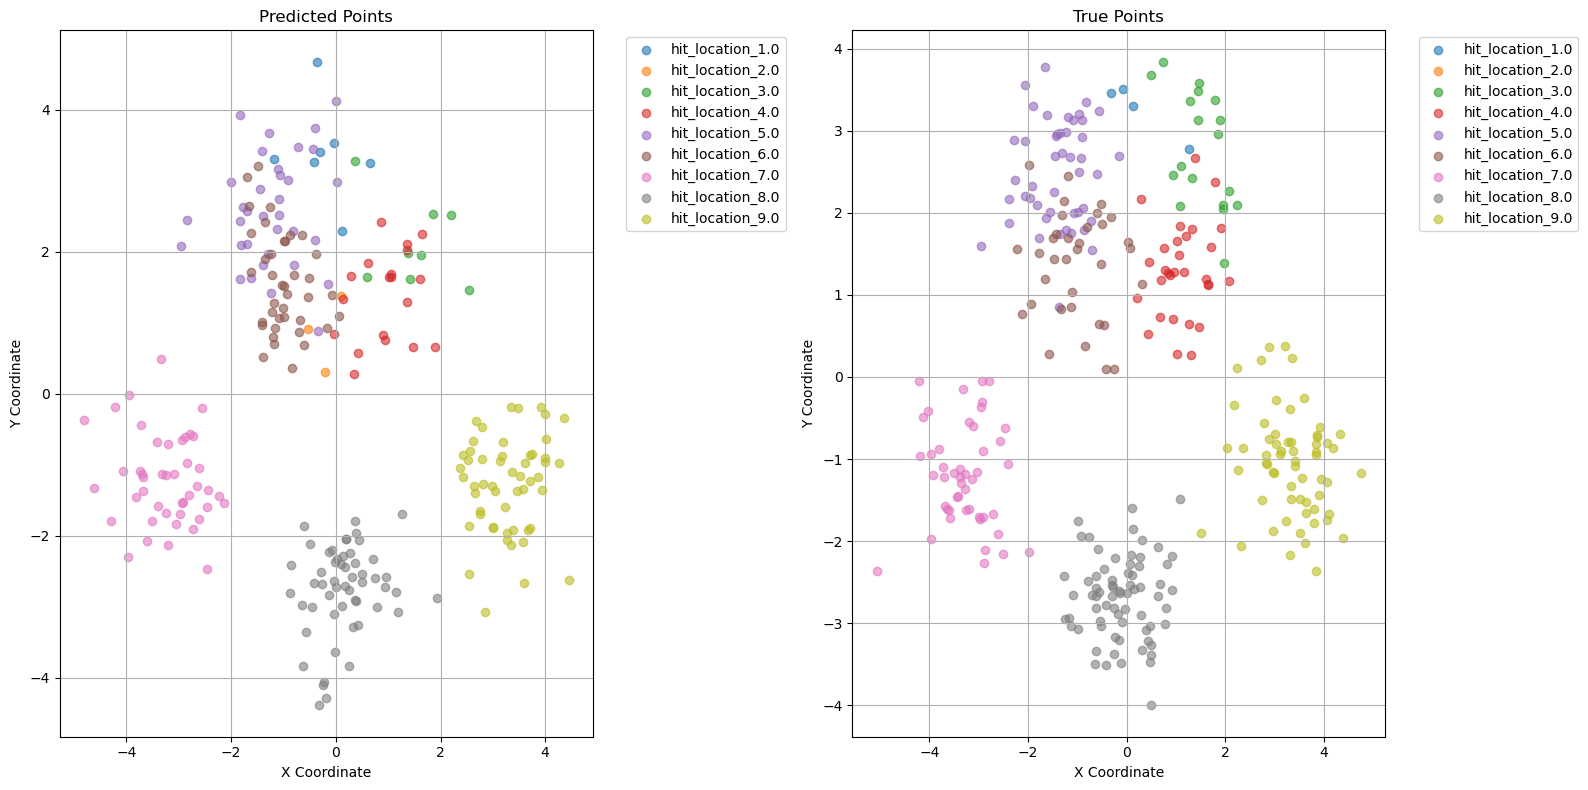

In [111]:


# Means for each hit_location
hit_location_means = {
    'hit_location_0.0': (-0.003983073196223652, -0.03831231896533057),
    'hit_location_1.0': (0.07101846859163305, 3.270289451225801),
    'hit_location_2.0': (0.0010434319683680874, 0.12995388865659924),
    'hit_location_3.0': (1.6558035414462313, 2.58956343859307),
    'hit_location_4.0': (1.0945771180430186, 1.4254147745752999),
    'hit_location_5.0': (-1.3642293834776613, 2.5143541837992647),
    'hit_location_6.0': (-0.8333675119971631, 1.4877088874113744),
    'hit_location_7.0': (-3.2246217715222376, -1.1634796383671433),
    'hit_location_8.0': (0.04059851353865746, -2.635759410393036),
    'hit_location_9.0': (3.2761718900605397, -1.1178633886172988)
}



predicted_points = df_pred.iloc[:,14:].sum().to_dict()
true_points = df_true.iloc[:,14:].sum().to_dict()

# Set standard deviation for sampling around the mean
std_dev = 0.6

# Create a figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot predicted points (Left plot)
for hit_loc, mean in hit_location_means.items():
    if hit_loc == "hit_location_0.0":
        continue #skip this one
    num_points = int(predicted_points[hit_loc])
    x_samples = np.random.normal(loc=mean[0], scale=std_dev, size=num_points)
    y_samples = np.random.normal(loc=mean[1], scale=std_dev, size=num_points)
    axs[0].scatter(x_samples, y_samples, label=hit_loc, alpha=0.6)

axs[0].set_title('Predicted Points')
axs[0].set_xlabel('X Coordinate')
axs[0].set_ylabel('Y Coordinate')
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].grid(True)

# Plot true points (Right plot)
for hit_loc, mean in hit_location_means.items():
    if hit_loc == "hit_location_0.0":
        continue #skip this one

    num_points = int(true_points[hit_loc])
    x_samples = np.random.normal(loc=mean[0], scale=std_dev, size=num_points)
    y_samples = np.random.normal(loc=mean[1], scale=std_dev, size=num_points)
    axs[1].scatter(x_samples, y_samples, label=hit_loc, alpha=0.6)

axs[1].set_title('True Points')
axs[1].set_xlabel('X Coordinate')
axs[1].set_ylabel('Y Coordinate')
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1].grid(True)

# Adjust layout to fit both subplots
plt.tight_layout()
plt.show()


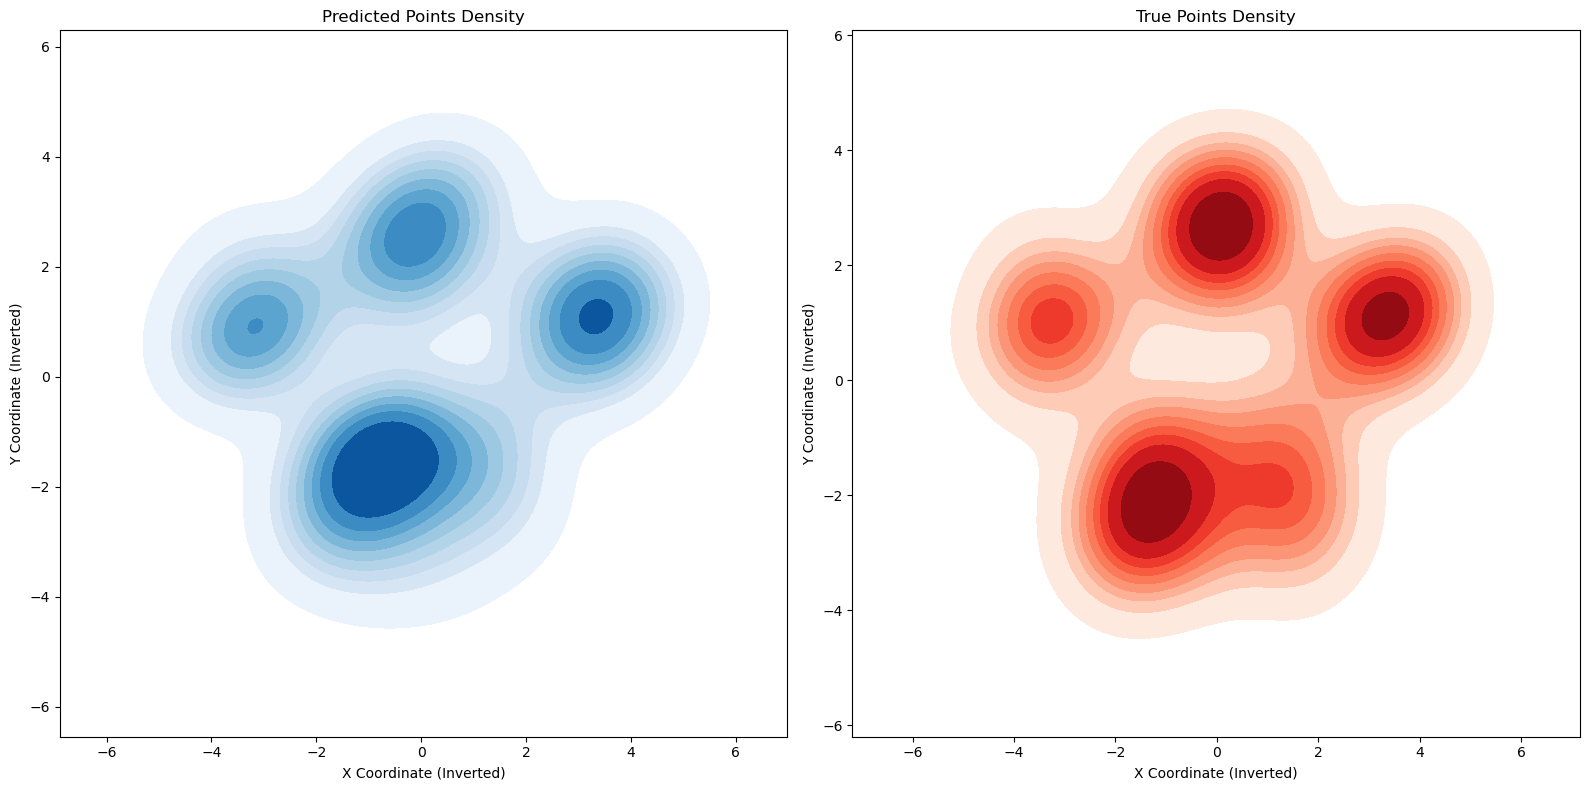

In [112]:
import seaborn as sns


# Invert the coordinates by flipping both x and y axes
def invert_coordinates(x, y):
    return x, -y

# Create a figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Collect predicted points for plotting density
pred_x, pred_y = [], []
for hit_loc, mean in hit_location_means.items():
    if hit_loc == "hit_location_0.0":
        continue #skip this one
    num_points = int(predicted_points[hit_loc])
    # Apply coordinate inversion
    x_samples, y_samples = invert_coordinates(
        np.random.normal(loc=mean[0], scale=std_dev, size=num_points),
        np.random.normal(loc=mean[1], scale=std_dev, size=num_points)
    )
    pred_x.extend(x_samples)
    pred_y.extend(y_samples)

# Plot kernel density estimate for predicted points
sns.kdeplot(x=pred_x, y=pred_y, fill=True, ax=axs[0], cmap='Blues')
axs[0].set_title('Predicted Points Density')
axs[0].set_xlabel('X Coordinate (Inverted)')
axs[0].set_ylabel('Y Coordinate (Inverted)')

# Collect true points for plotting density
true_x, true_y = [], []
for hit_loc, mean in hit_location_means.items():
    if hit_loc == "hit_location_0.0":
        continue #skip this one
    num_points = int(true_points[hit_loc])
    # Apply coordinate inversion
    x_samples, y_samples = invert_coordinates(
        np.random.normal(loc=mean[0], scale=std_dev, size=num_points),
        np.random.normal(loc=mean[1], scale=std_dev, size=num_points)
    )
    true_x.extend(x_samples)
    true_y.extend(y_samples)

# Plot kernel density estimate for true points
sns.kdeplot(x=true_x, y=true_y, fill=True, ax=axs[1], cmap='Reds')
axs[1].set_title('True Points Density')
axs[1].set_xlabel('X Coordinate (Inverted)')
axs[1].set_ylabel('Y Coordinate (Inverted)')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


